In [11]:
from model import base_function, network
import numpy as np

In [12]:
import matplotlib.pyplot as plt

In [13]:
net_G = network.define_g(gpu_ids=[0])

initialize network with normal


In [14]:
import torch
state_dict = torch.load('/tng4/users/skayasth/Yearly/2023/July/t-formers/checkpoints/rform/40000_net_G.pth')

In [15]:
net_G.load_state_dict(state_dict)

<All keys matched successfully>

In [23]:
with torch.no_grad():
    net_G.eval()
    i = torch.randn(1, 3, 768, 1024)
    j = torch.randn(1, 3, 768, 1024)
    out = net_G.forward(i.cuda(), j.cuda())

In [24]:
out.shape

torch.Size([1, 1, 768, 1024])

In [16]:
net_G.eval()

DataParallel(
  (module): Generator(
    (start): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(6, 48, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): GELU(approximate='none')
    )
    (trane256): Sequential(
      (0): TransformerEncoder(
        (attn): DAttn(
          (qkv): Conv2d(48, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (qkv_dwconv): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
          (project_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (feed_forward): FeedForward(
          (norm): InstanceNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (conv): Sequential(
            (0): Conv2d(48, 254, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): Conv2d(254, 254, kernel_size=(3, 3), stride=(1, 1), paddi

In [39]:

ne_data= np.load('input_data.npy')
ne_mask = np.load('input_mask.npy')

In [40]:
def split_image(image_array, size=(512, 512), overlap=0.50):
    channels, width, height = image_array.shape
    stride_width = int(size[0] * (1 - overlap))
    stride_height = int(size[1] * (1 - overlap))

    cropped_images = []
    positions = []

    for left in range(0, width - size[0] + 1, stride_width):
        for top in range(0, height - size[1] + 1, stride_height):
            right = left + size[0]
            bottom = top + size[1]
            cropped_array = image_array[:, left:right, top:bottom]
            cropped_images.append(cropped_array)
            positions.append((left, right, top, bottom))
            
    cropped_array = image_array[:, width-512:, :512]
    cropped_images.append(cropped_array)
    positions.append((width-512, width, 0, 512))
    cropped_array = image_array[:, width-512:, height-512:]
    cropped_images.append(cropped_array)
    positions.append((width-512, width, height-512, height))

    return np.array(cropped_images), positions

In [41]:
cropped_images,pos = split_image(ne_data[0], size=(512, 512), overlap=0.20)
cropped_masks,posm = split_image(ne_mask[0], size=(512, 512), overlap=0.20)

In [53]:
with torch.no_grad():
    outs = []
    for img, mask in zip(cropped_images,cropped_masks):
        
        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)
        
        test_img = torch.from_numpy(img).float().cuda()
        test_mask = torch.from_numpy(mask).float().cuda()
    
   
    
   
    # # test_img =  torch.from_numpy(ne_data_padded).float()
    # # test_mask = torch.from_numpy(ne_mask_padded).float()
    
    
    
        inp_img = test_img  * test_mask
    
        out = net_G.forward(inp_img.cuda(), test_mask.cuda())
        
        out_22 = out  * (1 - test_mask.cuda()) + inp_img.cuda()
        
        outs.append(out_22[0].cpu().detach().numpy())

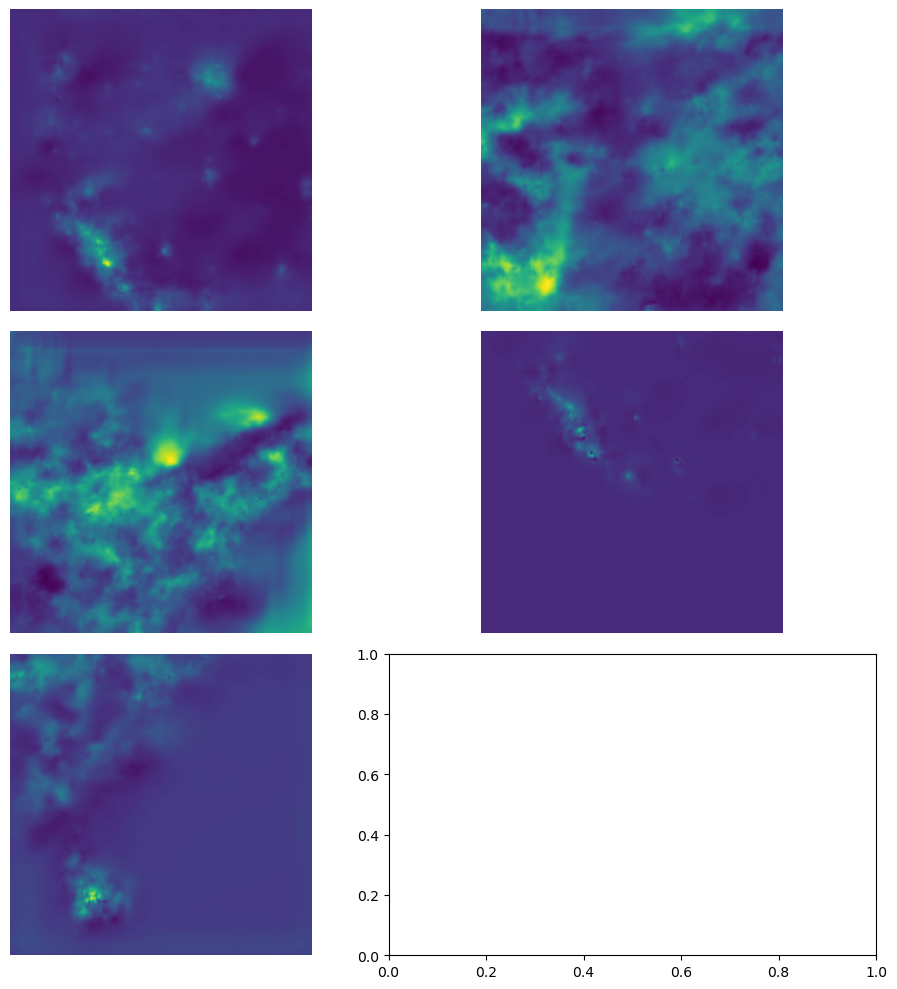

In [54]:
num_images = cropped_images.shape[0]
num_cols = int(np.sqrt(num_images))
num_rows = int(np.ceil(num_images / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(outs[i].transpose(1, 2, 0)[:, :, 0]*450.0)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [1]:
from data_prep_pus import Data_prep

In [2]:
data_path = "/tng4/users/skayasth/Yearly/2023/Jan/TCEQ/Data_for_PCNN"
create_data = Data_prep(data_path)

Loading Data
norm with max
191.0623723202353
Loading Mask
Mask 2018
Mask 2019
Mask 2020
Mask 2021


In [4]:
create_data.cmaq.shape, create_data.pus.shape, create_data.modis.shape, create_data.mask.shape

((301, 778, 1456), (778, 1456), (143, 778, 1456), (1461, 778, 1456))

In [9]:
import numpy as np
seed = 100
def Random_Station_Mask( mask):
        
        # Create a random number
        np.random.seed(seed)
        
        num_sum = np.sum(mask) # Total number of pixels with stations inside
        
        try:
            num = np.random.randint(int(np.floor(num_sum/16)), high=int(np.floor(num_sum/8))) #12,4
        except:
            num = 1

        # # Create a copy a mask (named mask_2) and keep only part of stations locations (based on the random number)
        mask2 = np.argwhere(mask == 1)
        indices_1 = np.arange(mask2.shape[0])
        np.random.shuffle(indices_1)
        mask2 = mask2[indices_1]
        mask_new = np.zeros((mask.shape[0], mask.shape[1]))
        mask_new[mask2[num:, 0], mask2[num:, 1]] = 1 # We replace all missing pixels with 1, because this is how PCNN works
        
        return mask_new.astype(np.float32)

In [25]:
rm = Random_Station_Mask(create_data.mask[0])

In [26]:
rm.shape

(778, 1456)

In [36]:
def _in(original_array, constant_values=0):
    
    padded_height, padded_width = 896, 1536


    # Get the original array shape
    original_height, original_width, original_channels= original_array.shape

    # Calculate the required amount of padding
    pad_height = padded_height - original_height
    pad_width = padded_width - original_width

    # Calculate the padding sizes for each dimension
    top_padding = pad_height // 2
    bottom_padding = pad_height - top_padding
    left_padding = pad_width // 2
    right_padding = pad_width - left_padding


    # Perform the zero-padding
    padded_array = np.pad(original_array, ((top_padding, bottom_padding), (left_padding, right_padding), (0, 0)), mode='constant', constant_values=constant_values)

    unpadded_array = padded_array[top_padding:top_padding+original_height, left_padding:left_padding+original_width, :]

    return padded_array.transpose(2,0,1)

In [37]:
rm_p = _in(np.expand_dims(rm, axis=-1),constant_values=1)

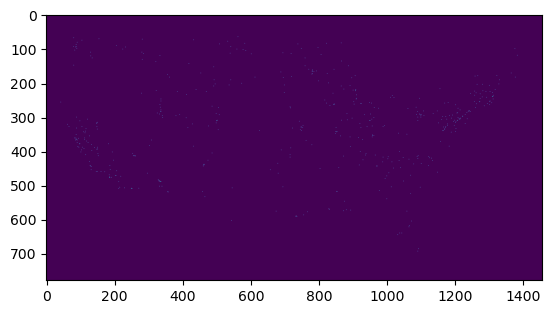

In [38]:
plt.imshow(rm)

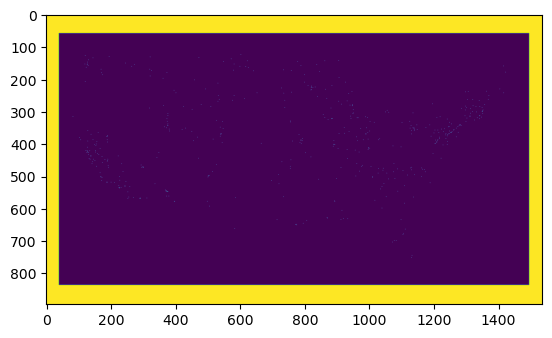

In [39]:
plt.imshow(rm_p[0])